long term :

```python
    def to_dict(self) -> Dict:
        """Convert long-term memory to dictionary for serialization."""
        return {
            "entries": {entry_id: entry.to_dict() for entry_id, entry in self.entries.items()},
        }
    
    @classmethod
    def from_dict(cls, data: Dict) -> 'LongTermMemory':
        """Create long-term memory from dictionary."""
        ltm = cls()
        
        for entry_id, entry_data in data["entries"].items():
            ltm.entries[entry_id] = MemoryEntry.from_dict(entry_data)
        
        return ltm
```


short term :
```python
    def to_dict(self) -> Dict:
        """Convert short-term memory to dictionary for serialization."""
        return {
            "capacity": self.capacity,
            "entries": [entry.to_dict() for entry in self.entries]
        }

    @classmethod
    def from_dict(cls, data: Dict) -> 'ShortTermMemory':
        """Create short-term memory from dictionary."""
        stm = cls(capacity=data["capacity"])
        for entry_data in data["entries"]:
            stm.add(MemoryEntry.from_dict(entry_data),self.model)
        return stm
```

Running performance tests...
Ops:   1000 | v1: 0.0143s, 8517.56 KB | v2: 0.0049s, 24.43 KB
Ops:   5000 | v1: 0.0238s, 67.27 KB | v2: 0.0135s, 25.86 KB
Ops:  10000 | v1: 0.0390s, 67.81 KB | v2: 0.0253s, 25.40 KB
Ops:  50000 | v1: 0.1889s, 70.34 KB | v2: 0.1318s, 26.01 KB
Ops: 100000 | v1: 0.3828s, 70.32 KB | v2: 0.2570s, 25.37 KB


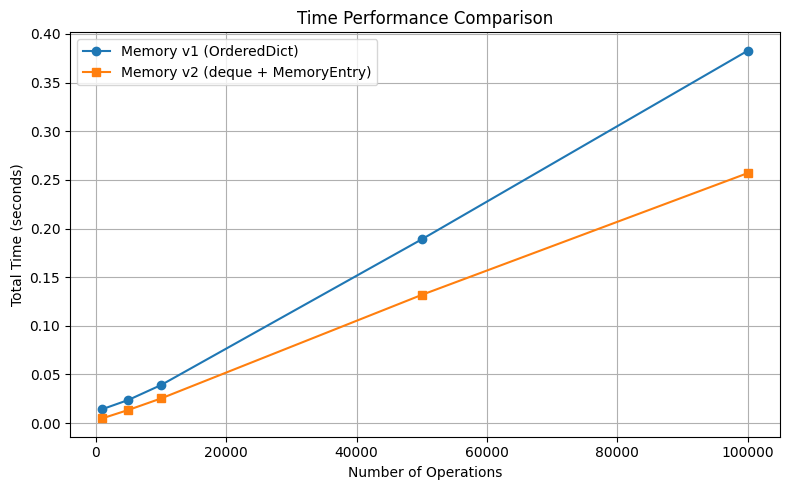

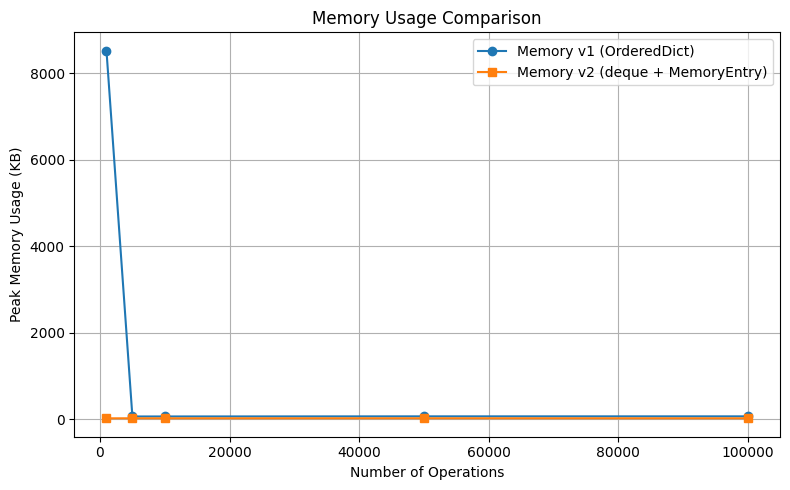

In [3]:
import time
import tracemalloc
import matplotlib.pyplot as plt

# Import memory implementations.
# Adjust these imports if your files are organized in packages.
from memory_V1 import Memory as MemoryV1
from memory_V2 import Memory as MemoryV2

# Dummy model classes with minimal attributes needed for testing
class DummyModelV1:
    def __init__(self):
        self.steps = 0

class DummyModelV2:
    def __init__(self):
        self.step = 0

# Dummy agent for v2
class DummyAgent:
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.memory = None

# Test function for memory_v1: repeatedly call remember() and measure time and memory.
def test_memory_v1(num_ops, capacity):
    model = DummyModelV1()
    mem = MemoryV1(model, agent_id=1, capacity=capacity)
    
    # Start timing and memory tracking
    start_time = time.time()
    tracemalloc.start()
    
    for i in range(num_ops):
        model.steps = i  # simulate the simulation step
        mem.remember(entry_content=f"data {i}", entry_type="test")
    
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    total_time = time.time() - start_time
    return total_time, peak

# Test function for memory_v2: repeatedly call remember_short_term() and measure time and memory.
def test_memory_v2(num_ops, stm_capacity):
    model = DummyModelV2()
    agent = DummyAgent(unique_id=1)
    mem = MemoryV2(agent, model, stm_capacity=stm_capacity)
    agent.memory = mem  # link agent and memory
    
    start_time = time.time()
    tracemalloc.start()
    
    for i in range(num_ops):
        model.step = i  # simulate the simulation step
        mem.remember_short_term(model, entry_content=f"data {i}", entry_type="test")
    
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    total_time = time.time() - start_time
    return total_time, peak

if __name__ == '__main__':
    # Settings: number of operations and fixed memory capacity (for fair comparison)
    ops_list = [1000, 5000, 10000, 50000, 100000]
    capacity = 100  # for memory_v1
    stm_capacity = 100  # for memory_v2 short-term memory

    # Lists to store performance results
    times_v1 = []
    times_v2 = []
    mem_v1 = []
    mem_v2 = []

    print("Running performance tests...")
    for n in ops_list:
        t1, m1 = test_memory_v1(n, capacity)
        t2, m2 = test_memory_v2(n, stm_capacity)
        times_v1.append(t1)
        times_v2.append(t2)
        mem_v1.append(m1 / 1024)  # convert bytes to kilobytes
        mem_v2.append(m2 / 1024)
        print(f"Ops: {n:6d} | v1: {t1:.4f}s, {m1/1024:.2f} KB | v2: {t2:.4f}s, {m2/1024:.2f} KB")

    # Plotting time performance
    plt.figure(figsize=(8, 5))
    plt.plot(ops_list, times_v1, marker='o', label='Memory v1 (OrderedDict)')
    plt.plot(ops_list, times_v2, marker='s', label='Memory v2 (deque + MemoryEntry)')
    plt.xlabel("Number of Operations")
    plt.ylabel("Total Time (seconds)")
    plt.title("Time Performance Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotting memory performance (peak memory in KB)
    plt.figure(figsize=(8, 5))
    plt.plot(ops_list, mem_v1, marker='o', label='Memory v1 (OrderedDict)')
    plt.plot(ops_list, mem_v2, marker='s', label='Memory v2 (deque + MemoryEntry)')
    plt.xlabel("Number of Operations")
    plt.ylabel("Peak Memory Usage (KB)")
    plt.title("Memory Usage Comparison")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
